# IMA207 - Practical work on SAR statistics

### Emanuele DALSASSO, Florence TUPIN, Cristiano ULONDU MENDES, Thomas BULTINGAIRE

### Statistics and despeckling

The practical work is divided in 3 parts

- A. empirical checking of the distributions seen in course for synthetic speckle
- B. computation of equivalent number of looks using images of physically homogeneous areas
- C. spatial multi-looking and implementation of the Lee filter

You have at your disposal several images of various areas acquired by different acquisition modes.
- An oceanfront in São-Paulo acquired by Sentinel-1 sensor (ESA) in GRD (Ground Range Detected) mode
- A farmland near from Bologne (Italy) acquired by TerraSAR-X sensor (ESA) in MGD (Multi Look Ground Range Detected) mode
- An area near from Rome acquired by TerraSAR-X sensor (ESA) in SLC (Single Look Complex) mode
- A temporal stack of images acquired at Flevoland in Netherlands by Alos sensor (JAXA) in SLC mode

Some useful functions are available in the file *mvalab.py*.

### Name: Haithem DAGHMOURA

#### Instructions

To solve this practical session, answer the questions below. Then export the notebook with the answers using the menu option **File -> Download as -> Notebook (.ipynb)**. Then [submit the resulting file on e-campus by next week.

### Import the libraries and packages we are going to use
The following cell imports all that is going to be necessary for the practical work

In [1]:
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py

--2024-06-09 09:21:00--  https://perso.telecom-paristech.fr/tupin/TPSAR/mvalab.py
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68071 (66K) [text/x-python]
Saving to: ‘mvalab.py’

mvalab.py           100%[===================>]  66.48K  --.-KB/s    in 0.1s    

2024-06-09 09:21:01 (475 KB/s) - ‘mvalab.py’ saved [68071/68071]



In [2]:
import scipy
from scipy import signal
import scipy.signal
import scipy as spy
import scipy.fftpack
from scipy import ndimage
from scipy import special
from scipy import ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import mvalab as mvalab
from urllib.request import urlopen
import cmath

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.max_open_warning'] = 30

## A. Single look data distributions

In this part, we will simulate an SLC (Single Look Complex) SAR image representing an homogeneous area and analyze the pdfs of its intensity and phase.

#### Single look data simulation

According to the Goodman model, the real and imaginary parts of each pixel of an SLC SAR image are independent and identically distributed according to a Gaussian distribution centered and of variance equal to the reflectivity of the pixel divided by 2.\
Choose randomly a reflectity value $R$ in the interval $[100, 200]$ and create a SLC SAR image of size $150\times 150$ representing an homogeneous area of reflectivity $R$.

Affichage d'une image reelle
plt.show dans visusar : image 150 x 150


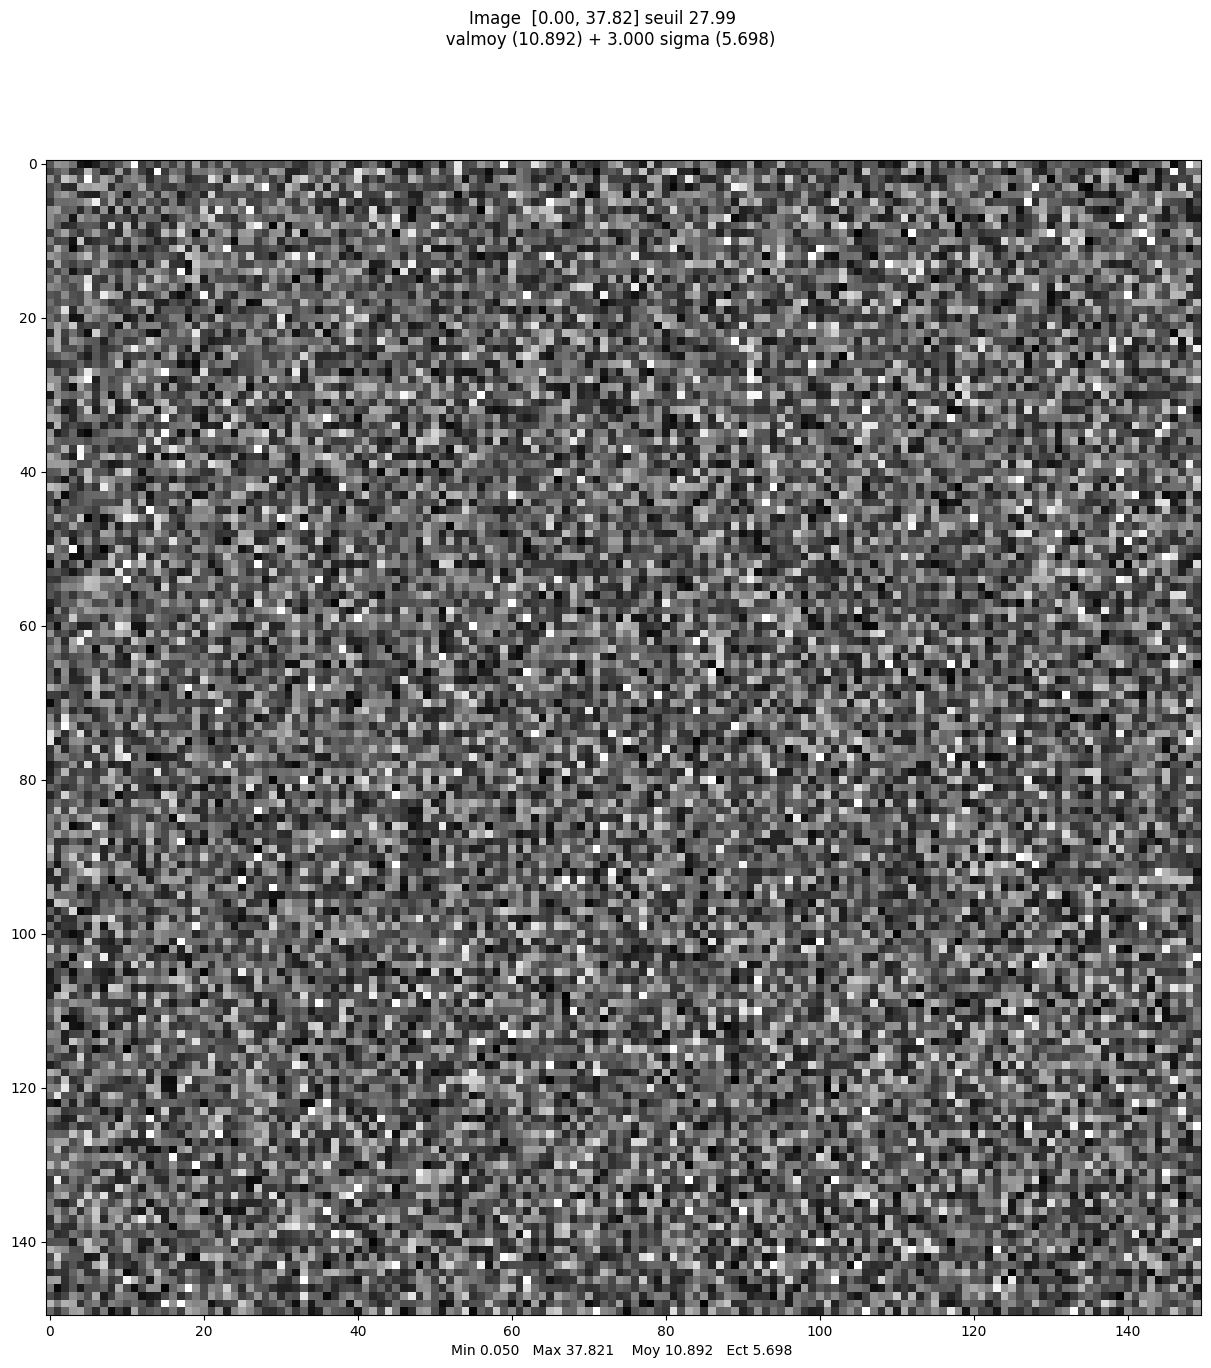

array([[ 9.54027495, 16.17643892, 15.51696343, ...,  6.7513477 ,
        27.98746008, 18.97176858],
       [ 6.9376187 , 10.07721358, 12.61086452, ...,  6.80629766,
        13.14209023, 12.40623945],
       [15.72800199,  7.81642196, 21.58641681, ...,  7.66700788,
         6.89234697, 20.70324128],
       ...,
       [ 8.06866084,  4.75558839,  7.68278059, ..., 13.64085755,
         8.76526149,  4.52853334],
       [20.26331302, 13.34214973, 19.32064188, ..., 10.46554154,
        11.42018295, 18.03345292],
       [11.25262602,  5.98923084, 11.08226927, ..., 12.8877869 ,
         6.74574881, 14.81531332]])

In [3]:
# Chose the reflectivity of the homogeneous area
R = 150 #complete

# Simulate the corresponding SLC image
ima_slc = np.sqrt(R/2)*(np.random.randn(150,150)+1j*np.random.randn(150,150)) #complete
mvalab.visusar(np.abs(ima_slc))

#### Data distributions for an homogeneous area

compute the distribution of the phase and intensity of your image.
Then, estimate the coefficient of variation:  
$\gamma=\frac{\sigma}{\mu}$ using intensity data (square of the modulus of the complex field)

In [5]:
# Compute the intensity and the phase
ima_int = np.abs(ima_slc)**2 #complete
ima_ph = np.angle(ima_slc) #complete

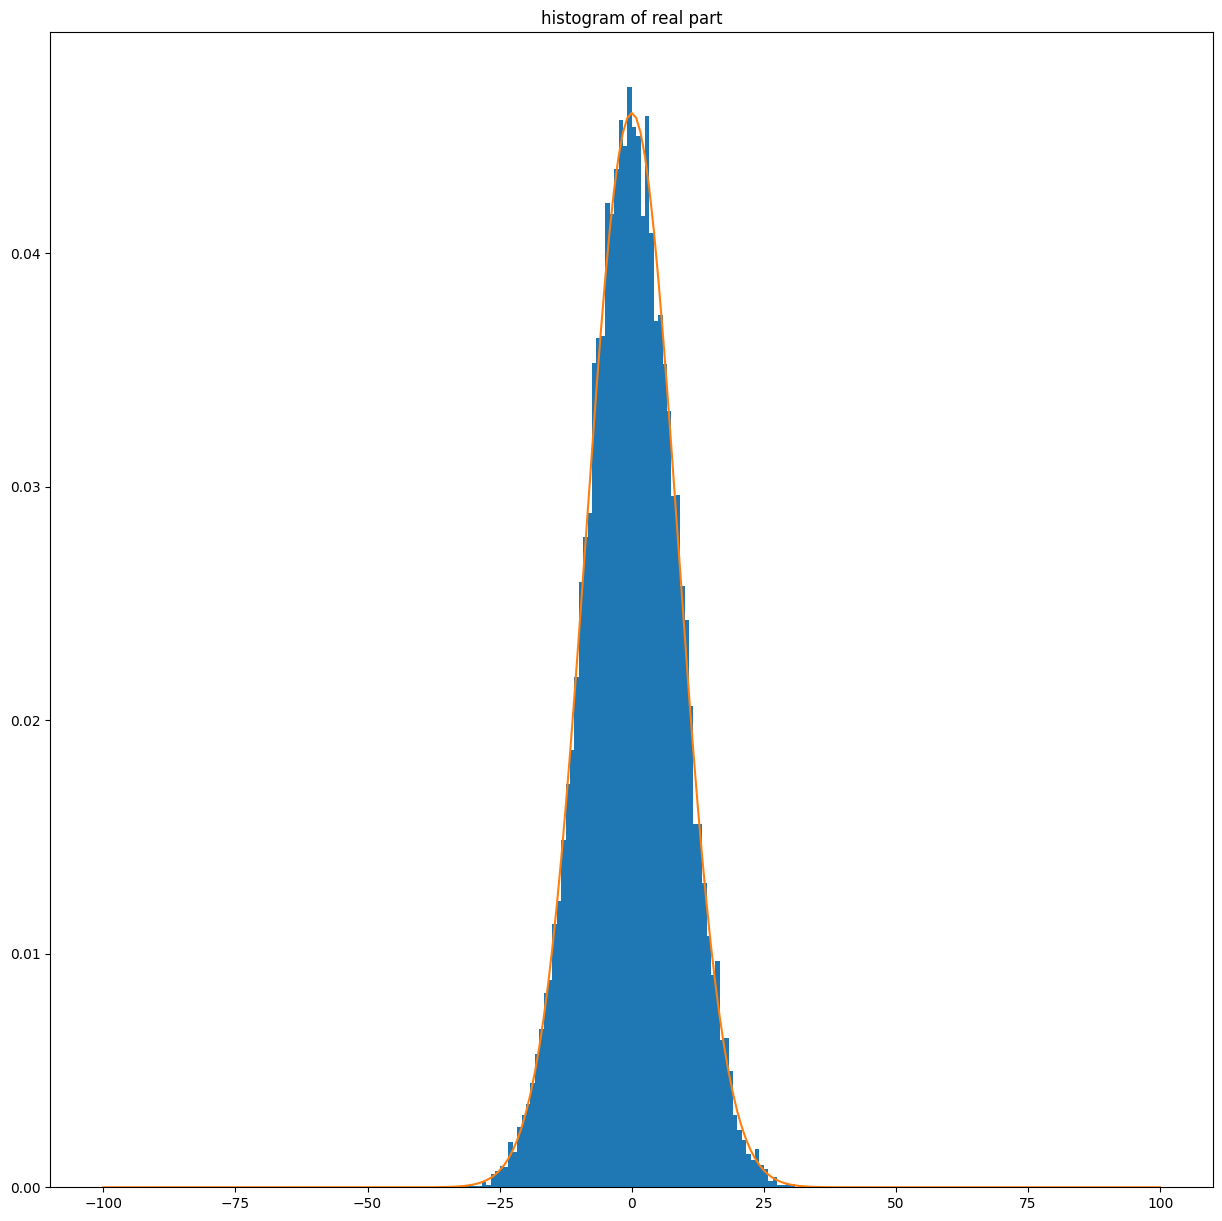

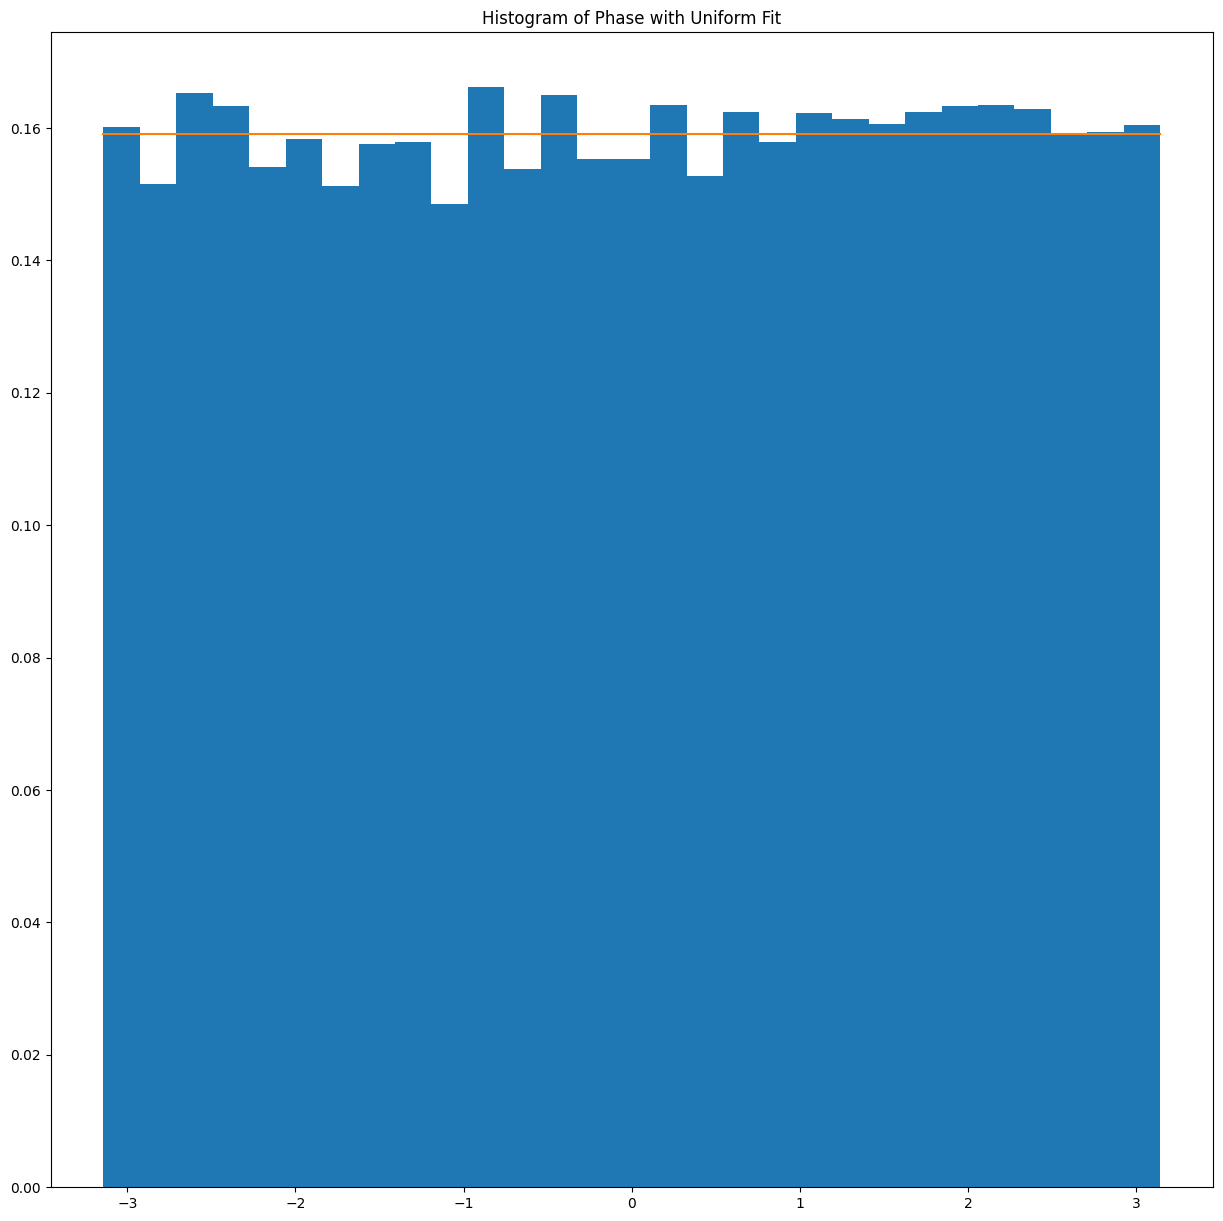

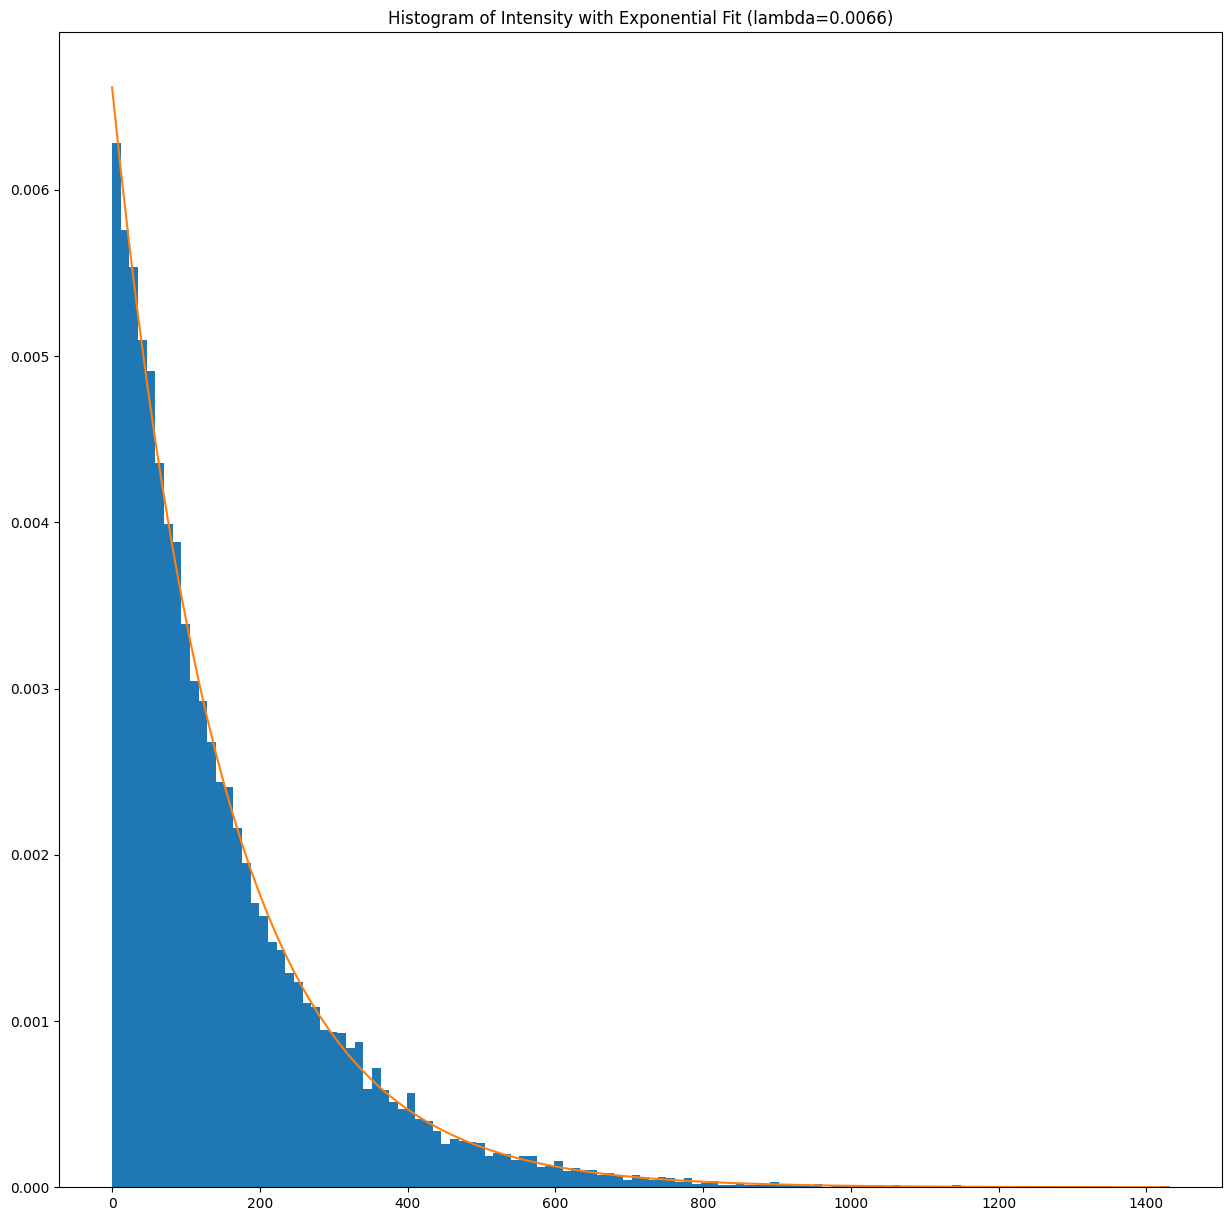

In [6]:
# Plot the histograms and verify they match the theoretical distribution
# Use the right range of values to plot the histogram
# Choose the right distribution to do the fitting

# fitting of the distributions
# use the following ones :
# Gaussian pdf : scipy.stats.uniform
# Rayleigh pdf : scipy.stats.rayleigh
# Exponential pdf : scipy.stats.expon

#example for real part of the data
plt.figure()
_, bins, _ = plt.hist(np.real(ima_slc).ravel(),bins='auto',density=True,range=[-100,100])  # Gaussian distribution
mu, sigma = scipy.stats.norm.fit(np.real(ima_slc))
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)
plt.title('histogram of real part')
plt.show()


# #complete for phase data: Uniform distribution
# plt.figure()
# _,bins,_ = plt.hist(ima_ph.ravel(),bins="auto",density=True,range=[-np.pi,np.pi])
# best_fit_line = scipy.stats.uniform.pdf(bins)
# #plt.plot(bins, best_fit_line)
# plt.title('histogram of phase')
# plt.show()

ima_ph = np.angle(ima_slc)
plt.figure()
_, bins, _ = plt.hist(ima_ph.ravel(), bins='auto', density=True, range=[-np.pi, np.pi])
best_fit_line = scipy.stats.uniform.pdf(bins, loc=-np.pi, scale=2*np.pi)
plt.plot(bins, best_fit_line)
plt.title('Histogram of Phase with Uniform Fit')
plt.show()


# #complete for intensity data: Exponential (Gamma) distribution

# Intensity data histogram and Exponential fit with a given lambda
lambda_param = 1 / np.mean(np.abs(ima_slc)**2)  # Calculate lambda as 1/mean intensity
intensity_data = np.abs(ima_slc)**2
plt.figure()
_, bins, _ = plt.hist(intensity_data.ravel(), bins='auto', density=True, range=[0, np.max(intensity_data)])
# Define the exponential PDF with the given lambda
best_fit_line = lambda_param * np.exp(-lambda_param * bins)
plt.plot(bins, best_fit_line)
plt.title(f'Histogram of Intensity with Exponential Fit (lambda={lambda_param:.4f})')
plt.show()



In [ ]:
# Compute the coefficient of variation on the homogeneous area in intensity
m_I = np.mean(intensity_data) #complete
sigma_I = np.std(intensity_data) #complete
coeff_var_I = sigma_I/m_I
print(coeff_var_I)

1.0054808324726783


### Question A.1.

Did you find the distributions seen in the course ? (recapitulate them).
Did you find the correct value for the coefficient of variation ? Could this coefficient be less than the theoretical value ?

### Answer A.1.
Yes, By plotting the respective distribution functions, we find the same distributions as seen in class. The phase follows a uniform distribution over [-pi,pi] and the intensity follows an exponential distribution.

Yes, we find the correct value for the coefficient of variation.

Yes, generally speaking we can find an empircal value that is less that the theoretical one. In fact, this is due to our slightly inaccurate supposition that the pixels are independant which is not entirly true

## B. Computation of the Equivalent Number of looks on homogeneous areas
In this part you have at your disposal 2 images of a part a ocean (São-Paulo) and a part of a field (Bologne, Italy). The first is acquired by Sentinel-1 GRD, and the second by TerraSAR-X GRD. The multi-looking has been done by the data provider (ESA, European Space Agency).

Use the value of the coefficient of variation to find the Equivalent Number of Looks (ENL) of the Sentinel-1 GRD and TerraSAR-X GRD data.
The formula is :
- $\gamma_I=\frac{1}{\sqrt{L}}$ for intensity data

In [7]:
# Download the images
!wget "https://partage.imt.fr/index.php/s/M3yeW5ozcsHyigR/download/s1_grd_saopaulo.npy"
!wget "https://partage.imt.fr/index.php/s/TTRfS6XKCzSM6cS/download/tsx_grd_bologne.npy"

--2024-06-09 09:35:02--  https://partage.imt.fr/index.php/s/M3yeW5ozcsHyigR/download/s1_grd_saopaulo.npy
Resolving partage.imt.fr (partage.imt.fr)... 193.48.235.12
Connecting to partage.imt.fr (partage.imt.fr)|193.48.235.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2097280 (2.0M) [application/octet-stream]
Saving to: ‘s1_grd_saopaulo.npy’

s1_grd_saopaulo.npy 100%[===================>]   2.00M   436KB/s    in 4.7s    

2024-06-09 09:35:07 (436 KB/s) - ‘s1_grd_saopaulo.npy’ saved [2097280/2097280]

--2024-06-09 09:35:07--  https://partage.imt.fr/index.php/s/TTRfS6XKCzSM6cS/download/tsx_grd_bologne.npy
Resolving partage.imt.fr (partage.imt.fr)... 193.48.235.12
Connecting to partage.imt.fr (partage.imt.fr)|193.48.235.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2097280 (2.0M) [application/octet-stream]
Saving to: ‘tsx_grd_bologne.npy’

tsx_grd_bologne.npy 100%[===================>]   2.00M   437KB/s    in 4.7s    

2024-06-09

Affichage d'une image reelle
plt.show dans visusar : image 250 x 250


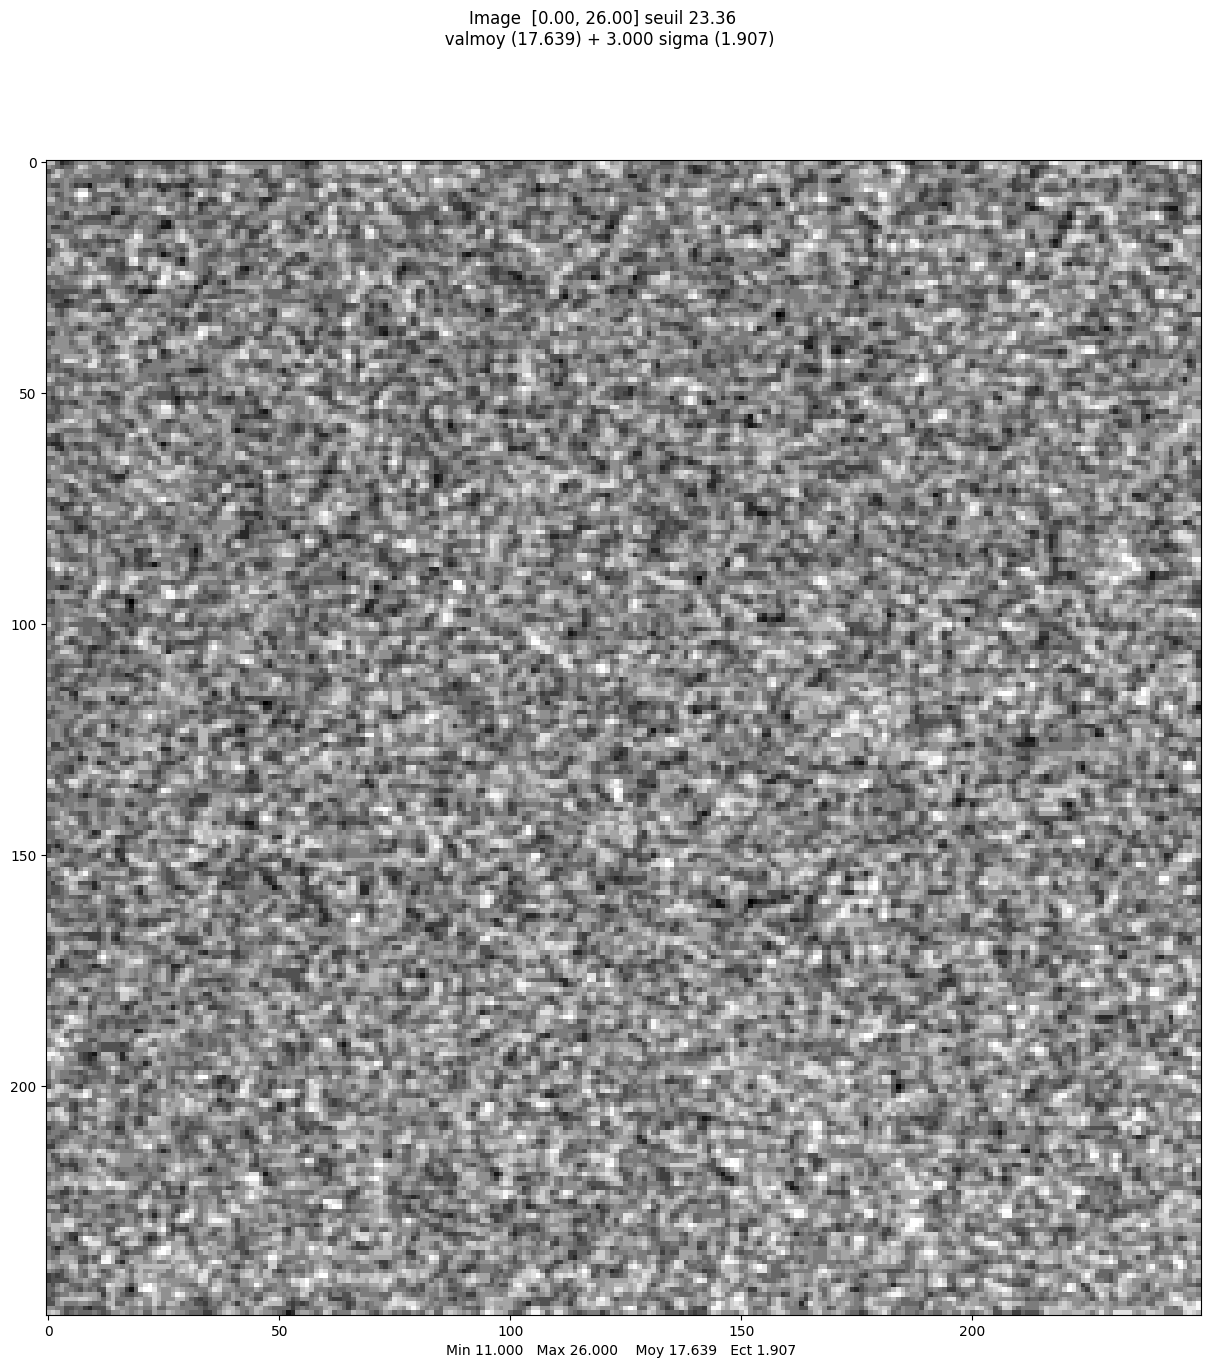

--- coeff var and L ---
0.21648477
21.33758686719461


In [8]:
im_s1grd = np.load("s1_grd_saopaulo.npy").astype(np.float32) #amplitude
im_s1grd_mer = im_s1grd[50:300, 100:350]
mvalab.visusar(im_s1grd_mer)

# compute coefficient of variation and number of looks
coeff_var_grd = (np.abs(im_s1grd_mer)**2).std()/(np.abs(im_s1grd_mer)**2).mean() #complete
L_grd = 1/coeff_var_grd**2 #complete
print('--- coeff var and L ---')
print(coeff_var_grd)
print(L_grd)

Affichage d'une image reelle
plt.show dans visusar : image 250 x 250


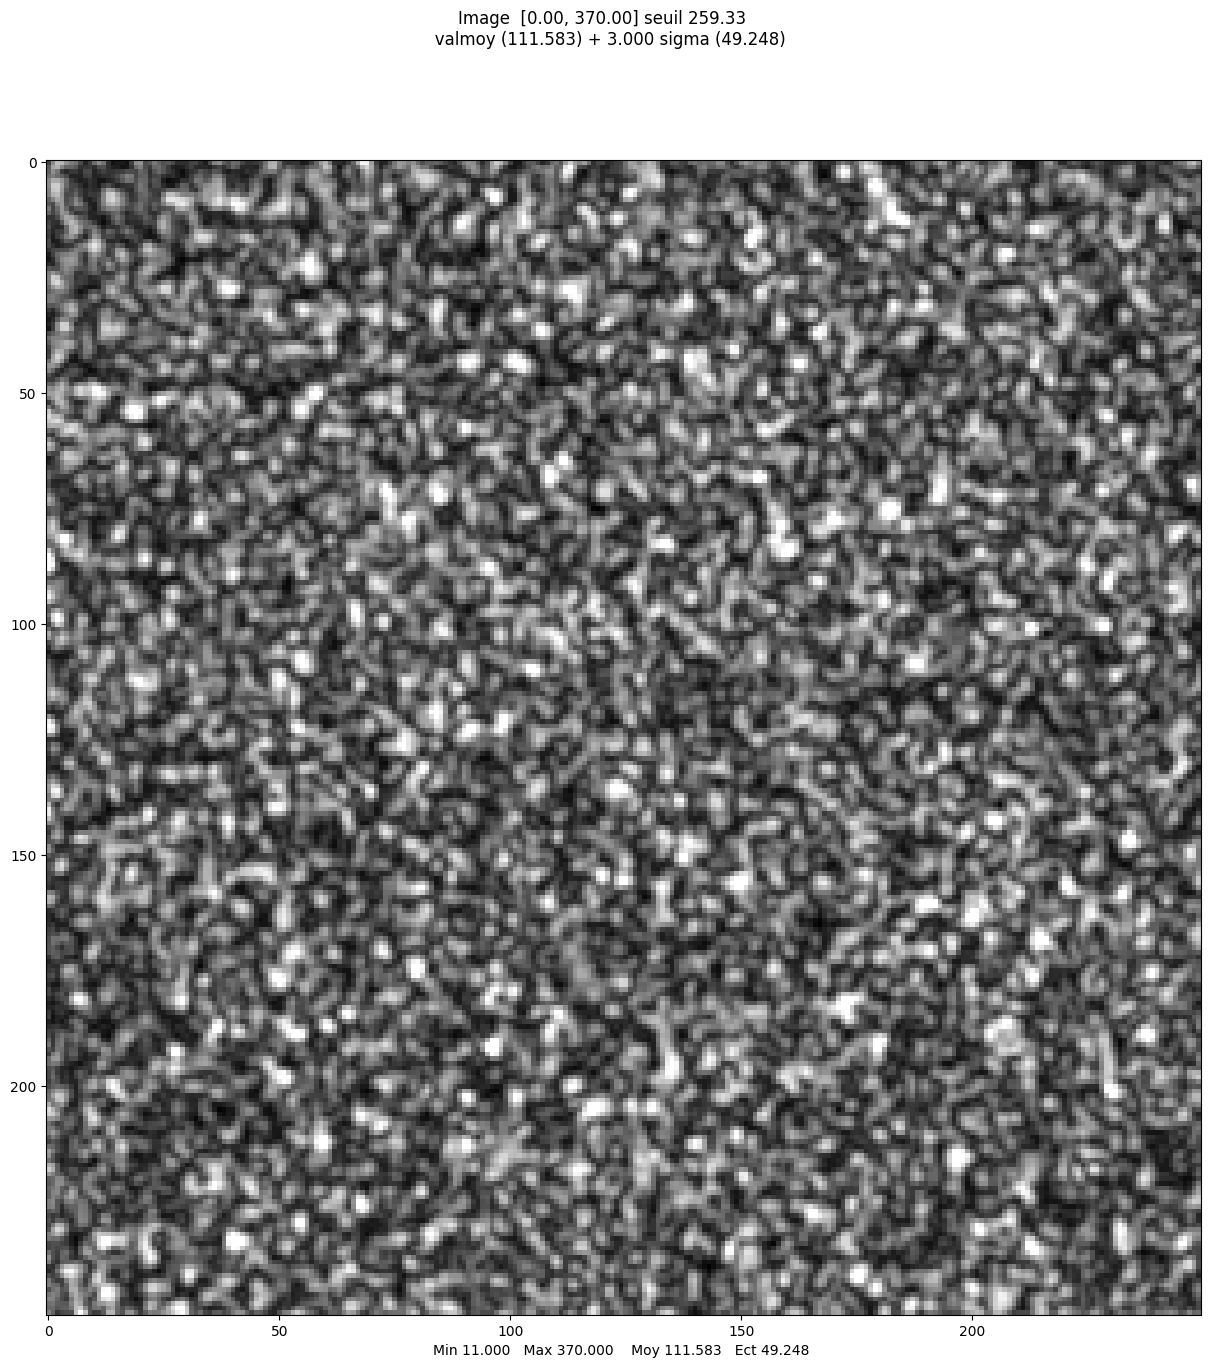

--- coeff var and L ---
0.90074235
1.2325337872691504


In [9]:
im_tsxgrd = np.load("tsx_grd_bologne.npy").astype(np.float32) #amplitude
im_tsxgrd_champ = im_tsxgrd[700:950, 300:550]
mvalab.visusar(im_tsxgrd_champ)

coeff_var_grd = (np.abs(im_tsxgrd_champ)**2).std()/(np.abs(im_tsxgrd_champ)**2).mean() #complete
L_grd = 1/coeff_var_grd**2 #complete
print('--- coeff var and L ---')
print(coeff_var_grd)
print(L_grd)

# compute coefficient of variation and number of looks


### Question B.1
Comment the number of looks you have found for GRD date from Sentinel-1 and TerraSAR-X (is it an integer value ? why not ? what does it mean ?).

### Answer B.1
The number of looks that we obtain by applying the formula is not an integer in both cases. This is due to the fact that our hypothesis about the looks being iid is not entirely correct. Specifically the independance isn"t true. Thus when we conducted our computation in the formula we were using an std that is smaller than it should be (since the the looks are dependent the average is not devided by a factor but is rather bigger than what we get) leading to a number of looks smaller than it should be.


## C. Spatial multi-looking and implementation of the Lee filter

In this part we will try simple speckle reduction method using the following step :
- first we will compute a mean filter
- then we will compute the local coefficient of variation (using the same size for the moving window)
- finally we will combine these two results to obtain the Lee filter.

## C.1 Computation of the mean filter
Compute the mean filter using a 2D convolution.

In [24]:
# Download the image
!wget "https://partage.imt.fr/index.php/s/cbRqjnSJEfD2zJ8/download/tsx_slc_rome.npy"

--2024-06-09 10:42:29--  https://partage.imt.fr/index.php/s/cbRqjnSJEfD2zJ8/download/tsx_slc_rome.npy
Resolving partage.imt.fr (partage.imt.fr)... 193.48.235.12
Connecting to partage.imt.fr (partage.imt.fr)|193.48.235.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388736 (8.0M) [application/octet-stream]
Saving to: ‘tsx_slc_rome.npy.1’

tsx_slc_rome.npy.1  100%[===================>]   8.00M   445KB/s    in 19s     

2024-06-09 10:42:48 (441 KB/s) - ‘tsx_slc_rome.npy.1’ saved [8388736/8388736]



In [41]:
ima_tsxslc = np.load("tsx_slc_rome.npy") #amplitude

# take the intensity
ima_int = np.abs(ima_tsxslc)**2 #complete
mvalab.visusar(np.sqrt(ima_int))

# create the average window
size_window = 5
mask_loc = (1/size_window**2 )*np.ones((size_window,size_window)) #complete

# compute the mean image (intensity data)
ima_int_mean = scipy.signal.convolve2d(ima_int,mask_loc,mode='same') #complete

# display the result
mvalab.visusar(np.sqrt(ima_int_mean))

Output hidden; open in https://colab.research.google.com to view.

### Question C.1
What is the effect of the mean filter ? (advantages and drawbacks). What is the influence of the window size ?

### Answer C.1
The mean filter is used in order to average the values inside the window. The main advatage that we do not lose the resolution of the given image (we still get an image of the same shape as the input) and that we still reduce somewhat the effect of noise in homogenious areas. However the main drouback that we lose alot of border information and the image becomes more blurred.

By increasing the window size we increase the two mentioned effects. High values leads to a better performance in the homogenous areas and worse results in borders.

## C.2 Lee filter

Given a neighborhood, the Lee filter of an image $I_s$ can be computed by the following steps:

*   Compute the local mean of the image $\hat{\mu}_{s}$
*   Compute $k_s$ given by:
$$
  k_s=1- \frac{\gamma_{Sp}^2}{\hat{\gamma}_s^2}
$$
where $\gamma_{Sp}$ is the theoretical value of the coefficient of variation for a pure speckle ($\gamma_{Sp}=\frac{1}{\sqrt{L}}$ for a L-look intensity image), and $\hat{\gamma}_s$ is the empirical value of the coefficient of variation for the given neighborhood.
*   Compute the final filtered image
$$
  \hat{I}_s= \hat{\mu}_{s}+k_s (I_s-\hat{\mu}_{s})
$$

Create a function performing Lee filter on an image, for a given neighborhood and number $L$ of look.

Then, knowing that a SLC image is a 1-look image, compute the Lee filter on the intensity image of "ima_tsxslc"

In [48]:
def lee_filter(im, neighborhood=7, L=1, visualize=False):

  # Mask
  mask = (1/neighborhood**2)*np.ones((neighborhood,neighborhood)) #complete

  # Compute local mean image
  im_mean = scipy.signal.convolve2d(im,mask,mode='same') #complete

  # Compute local coefficient of variation (thanks to local variance and local mean)
  im_var = scipy.signal.convolve2d(im**2,mask,mode='same')-im_mean**2 #complete
  ks = 1-(1/L)/(im_var/im_mean**2) #complete
  ks = np.clip(ks, 0, 1)

  # Compute Lee filter
  #print(f"im_mean.shape: {im_mean.shape}, im.shape: {im.shape}, ks.shape: {ks.shape}   ")
  filtered_im = im_mean+ks*(im-im_mean) #complete

  # Visualizations
  if visualize:
    mvalab.visusar(np.sqrt(im_mean))
    mvalab.visusar(np.sqrt(im_var))
    mvalab.visusar(np.sqrt(im_var/im_mean**2))
    mvalab.visusar(np.sqrt(ks))

  return filtered_im


lee_filtered_int = lee_filter(np.abs(ima_tsxslc)**2, neighborhood=5, L=1, visualize=True) #complete
mvalab.visusar(np.sqrt(lee_filtered_int))

Output hidden; open in https://colab.research.google.com to view.

### Question C.2
Which information is enhanced in the image of the local standard deviation ? In the image of the local coefficient of variation ? Which one is the more useful ?

### Answer C.2
In the image of the local standard deviation, the heterogenity of the area is the information that is being enhanced.

In the image of the local coefficient of variation, the heterogenity of the area is the inforamtion that is being enhanced aswell. However in the second image, the values are normalized with the pixels means, leading to a more useful information

### Question C.3

Compare the results of the mean filter and the Lee filter. Study the influence of the size of the window of the filters.


### Answer C.3
When comparing the results of both filters, we noitice that overall the lee filter yields better results. In fact, due to its capability to chose whether to average of take the image as it depending on the coefficient of variation, the lee filter is able to yield better results. However, we notice the appearnce of bright new points that seem to be artifacts. increasing the window size will result in aggregating more points in the computation of $\bar I$. This leads to more homogeneous areas being aggregated when we have a homogenous zone. In the heterogenous zones this leads to keeping the images as it is since in these areas we have a very large coefficient of vatiation.

## Filtering of image "Lely" and comparison with a deep learning algorithm
In this part, we will repeat the process done above to denoise a crop of image "Lely" using the Lee filter. Then, we will compare it with the result of a deep learning algorithm called SAR2SAR (https://arxiv.org/abs/2006.15037).

## C.4 Denoised image: SAR2SAR
The Lee filter presents some limits. More recent approaches to suppress noise rely on sofisticated algorithms. You can plot the image of Lely denoised using a deep learning algorthm called SAR2SAR and compare visually the result with the image filtered using the Lee filter.
  

In [33]:
# Download the image
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.IMA
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.dim

--2024-06-09 11:02:18--  https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.IMA
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52428800 (50M)
Saving to: ‘lely_tuple_multitemp.IMA’

lely_tuple_multitem 100%[===================>]  50.00M  16.8MB/s    in 3.0s    

2024-06-09 11:02:22 (16.8 MB/s) - ‘lely_tuple_multitemp.IMA’ saved [52428800/52428800]

--2024-06-09 11:02:23--  https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/multitemp/lely_tuple_multitemp.dim
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29
Savi

imz2mat : version janvier 2018.  Fichier à ouvrir : lely_tuple_multitemp.IMA
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
Dans ximaread : lecture du canal 0/25
image en .IMA
image en .IMA
Fichier .dim version longue (lecture 3eme parametre) 
Fichier .dim version longue (lecture 4eme parametre)
image en .ima  512   512   canaux: 25  verif :  1
512 512
-type CFLOAT
lecture de  lely_tuple_multitemp.IMA  en quelconque 512 512 25  offset  0 <f 4  complex 1 blocksize 2097152
Boucle de lecture entre 0 et 25   sur 25 canaux
Lecture du canal 1/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 2/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 3/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 4/25
Données complexes (standard). Nouvelle version de imz2mat  <f
Lecture du canal 5/25
Données complexes (standard). Nouvelle version de imz2mat 

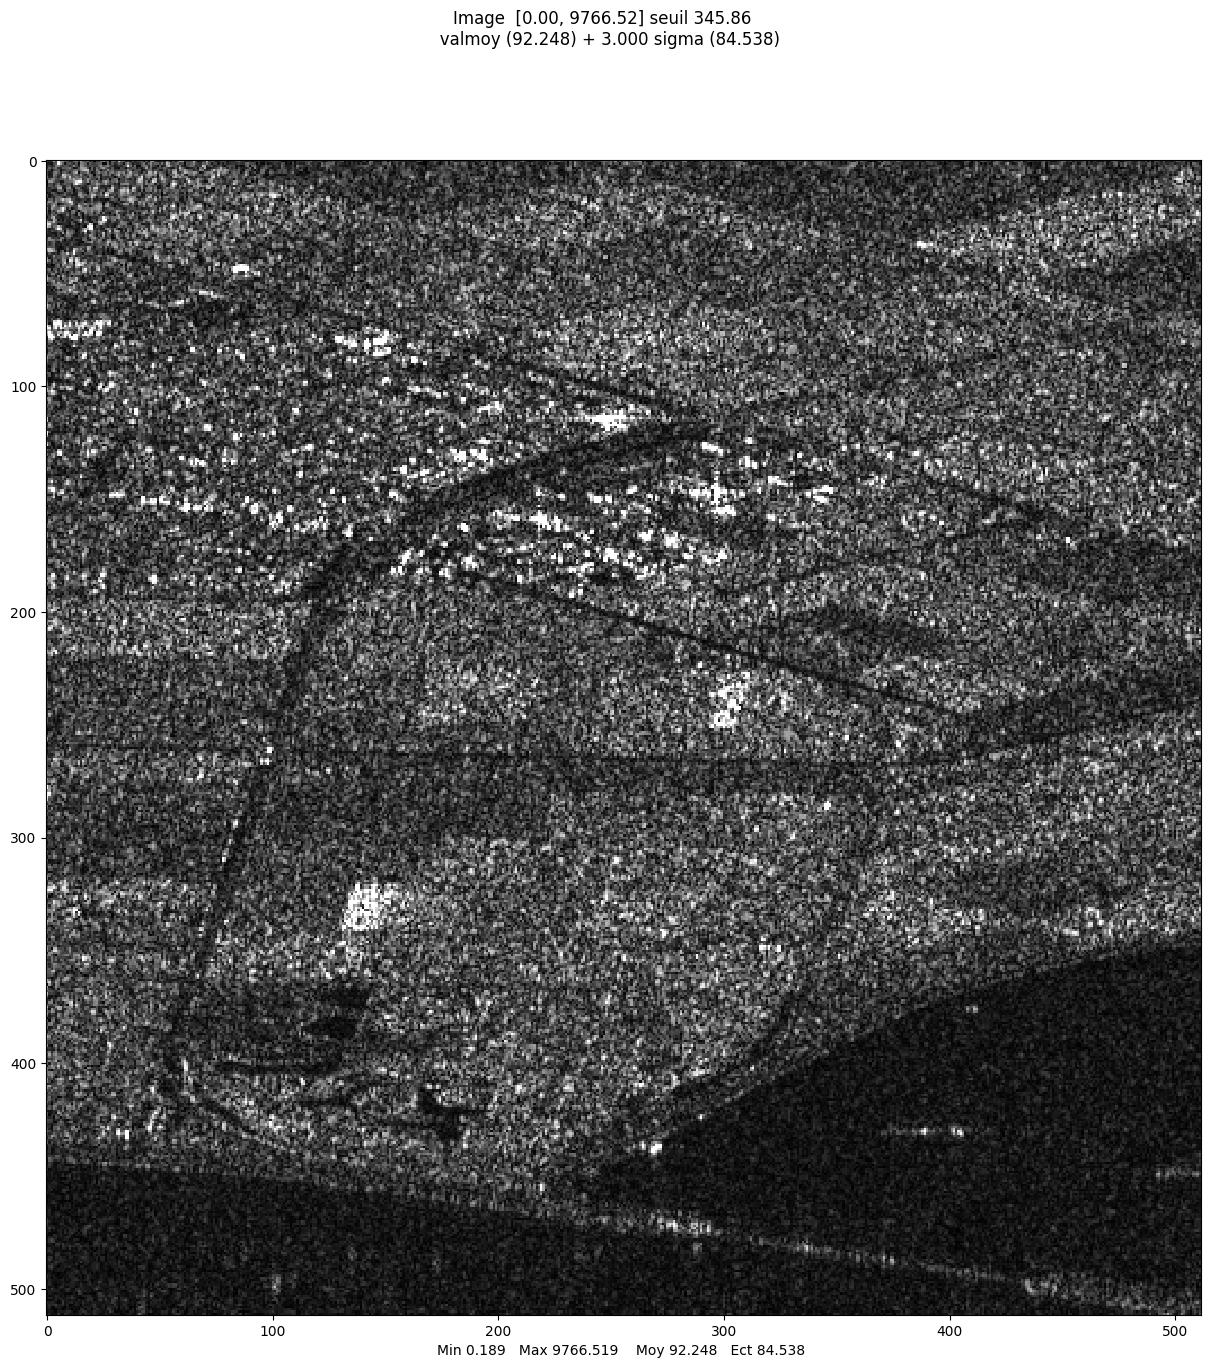

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


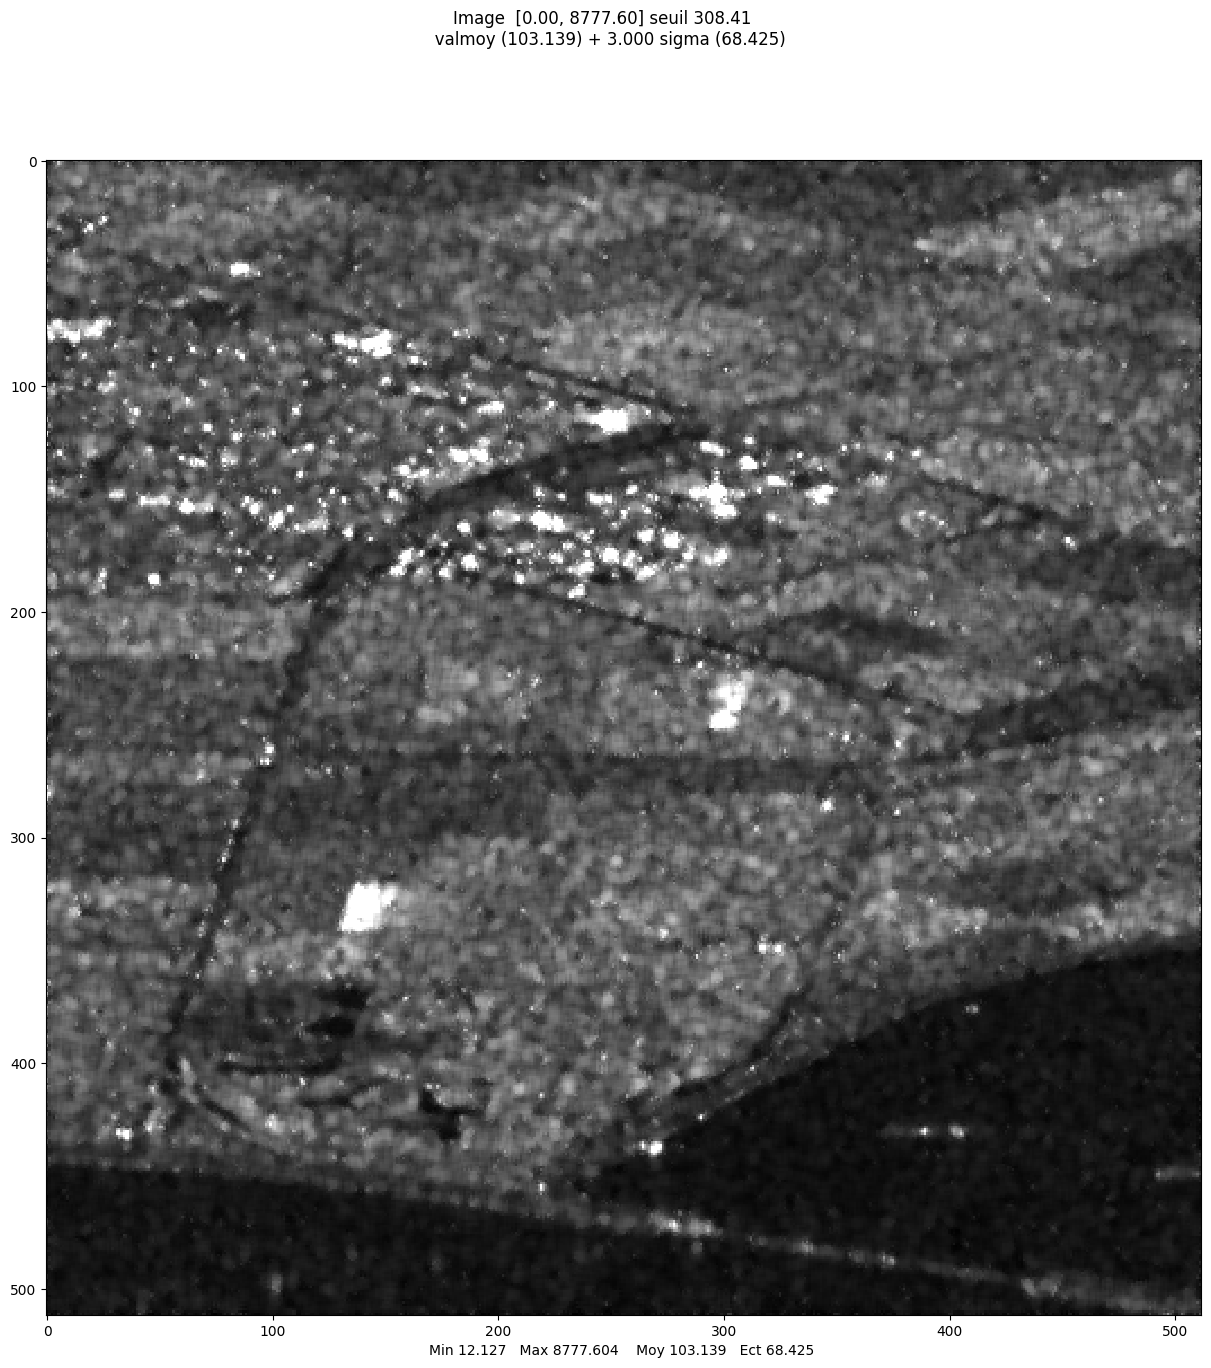

array([[ 68.89086899,  59.00943903,  78.62079749, ...,  47.64057136,
         50.05070571,  47.92380963],
       [ 46.45969791,  53.33040287,  76.81468018, ...,  95.19890164,
         83.06174815,  47.57592921],
       [ 56.35291552,  82.56396901, 101.52331965, ...,  99.81779615,
         84.89170049,  73.87549192],
       ...,
       [ 29.61453151,  32.47175043,  36.81431802, ...,  75.2869592 ,
         72.15065475,  60.58204956],
       [ 19.80323135,  28.79317517,  30.65607682, ...,  69.86896354,
         63.91231341,  70.15091784],
       [ 24.17833487,  41.23106887,  19.58726139, ...,  71.86461615,
         41.5469726 ,  99.32781523]])

In [40]:
part_lely_slc = mvalab.imz2mat('lely_tuple_multitemp.IMA')[0] #date is on thrid axis of part_lely_slc
part_lely_slc = part_lely_slc[:,:,0] #single look complex image
mvalab.visusar(np.abs(part_lely_slc))

# using your previous code, filter the image part_lely_int with the Lee filter
lee_filtered = lee_filter(np.abs(part_lely_slc)**2, neighborhood=5, L=1, visualize=False) #complete
mvalab.visusar(np.sqrt(lee_filtered))

--2024-06-09 11:05:11--  https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.IMA
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26214400 (25M)
Saving to: ‘lely_tuple_multitemp_SAR2SAR.IMA’

lely_tuple_multitem 100%[===================>]  25.00M  12.6MB/s    in 2.0s    

2024-06-09 11:05:14 (12.6 MB/s) - ‘lely_tuple_multitemp_SAR2SAR.IMA’ saved [26214400/26214400]

--2024-06-09 11:05:15--  https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.dim
Resolving perso.telecom-paristech.fr (perso.telecom-paristech.fr)... 137.194.22.227, 2a04:8ec0:0:a::89c2:16e3
Connecting to perso.telecom-paristech.fr (perso.telecom-paristech.fr)|137.194.22.227|:443... connected.
HTTP request sen

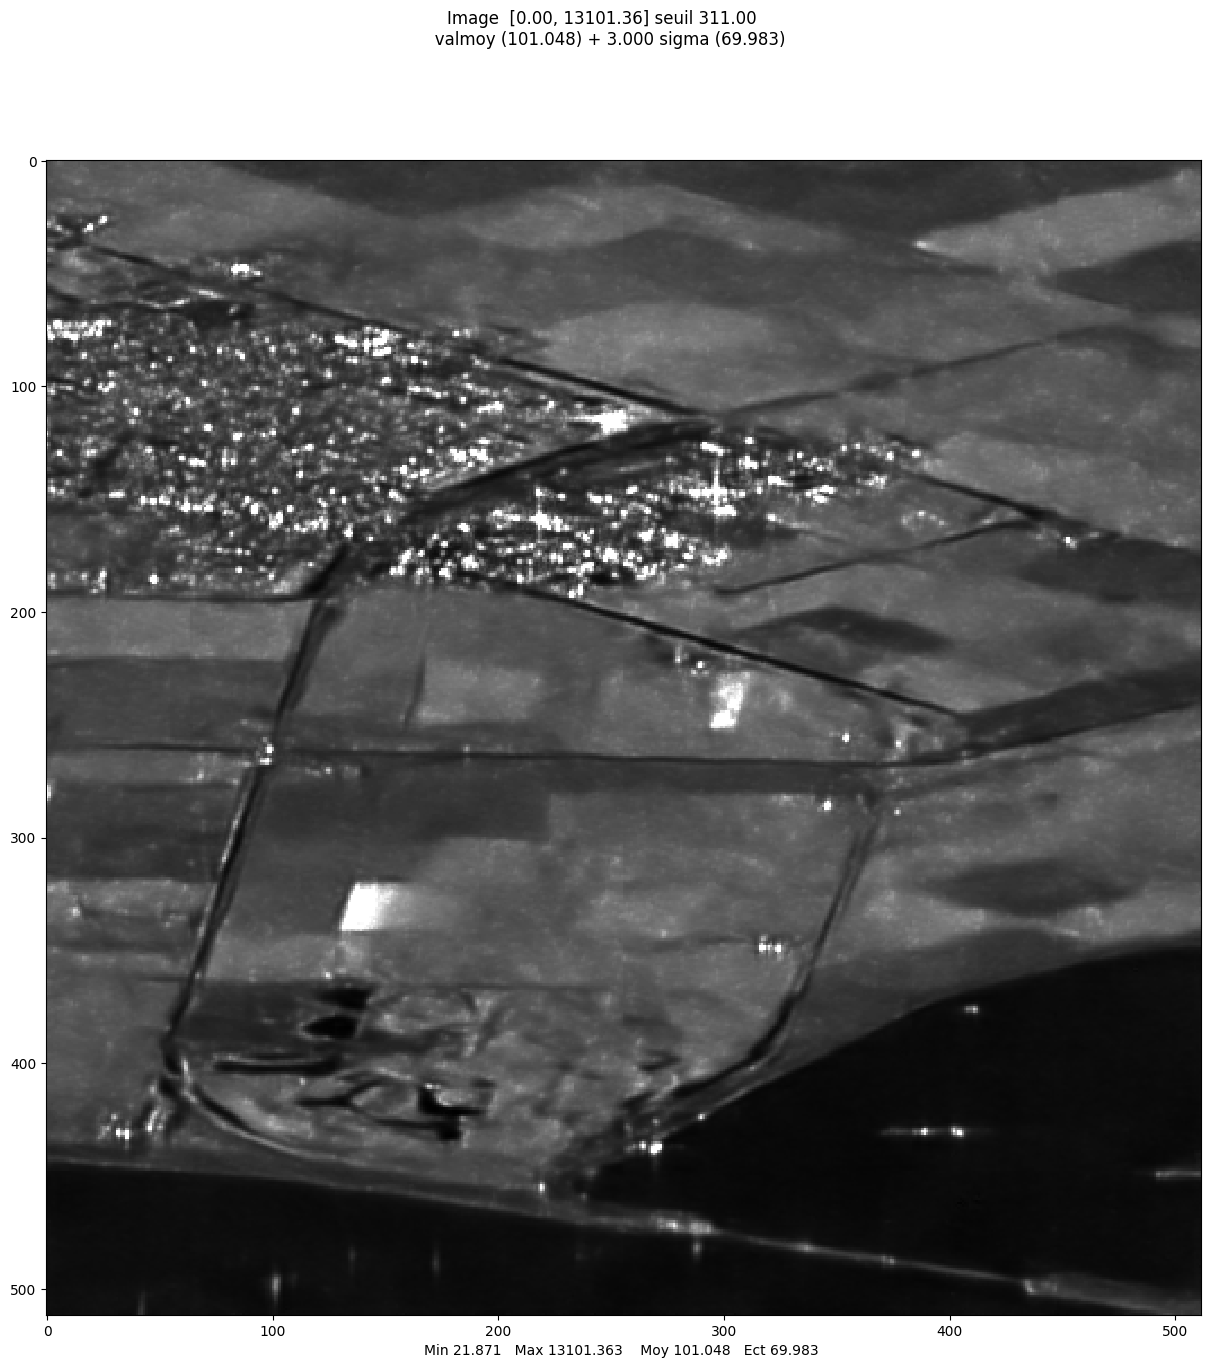

array([[108.26735687, 108.92593384, 117.21216583, ...,  87.13925171,
         89.79171753,  89.75721741],
       [105.54544067, 111.25749207, 116.15348053, ...,  95.23865509,
         96.19988251,  95.58480072],
       [105.72384644, 114.29315186, 116.50016022, ..., 100.59217072,
        100.78230286, 100.22771454],
       ...,
       [ 40.31035233,  38.88003159,  38.09856415, ...,  82.76222992,
         81.49038696,  81.83437347],
       [ 39.99552917,  38.5390358 ,  38.96235657, ...,  84.42482758,
         84.06273651,  83.64545441],
       [ 40.69298935,  38.59126282,  38.61891174, ...,  81.21070862,
         82.10493469,  87.46295166]])

In [39]:
# this image has already been processed by a CNN based filter
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.IMA
!wget https://perso.telecom-paristech.fr/tupin/TPSAR/pilelely/denoised_SAR2SAR/lely_tuple_multitemp_SAR2SAR.dim
im_lely_multitemp_denoised = mvalab.imz2mat('lely_tuple_multitemp_SAR2SAR.IMA')
im1_d = np.abs(im_lely_multitemp_denoised[0][:,:,0]) #amplitude
mvalab.visusar(im1_d)

### Question C.4
Do a comparison between the CNN filtering and the Lee filter. Comment the two results. Are homogeneous areas well restored? Do the methods preserve edges and fine structures? Are artifacts introduced?

### Answer C.4
The CNN filtering yields ,by far, a much higher performance compared to the Lee filtering. The CNN is able to distinguish between the homogeneous areas and the heterogenous ones, effectivly denoising the images. In opposition, the Lee filter performs poorely in these areas where it still leaves the noise. We can see this for instance in the sea (the large black zone in bottom right) In the CNN case we get a nice contigous black area. Whearas with the Lee filter the noise still persists. In addition the CNN is able to perserve most of the edges and deals well with the fine structers. In opposition the Lee filter strugles to define these structures.

Finally, we noitice that the Lee filter introduces artifacts while the CNN does not.



## C.5 Method noise
Performances of a denoising algorithm can be visually interpreted by looking at the *residual noise* (i.e. the ratio between the noisy image and the denoised image, in intensity). For a quantitative evaluation, we can look at the noise statistics, knowing that, in intensity, statistics of speckle S are:
- $\mu_S=1$
- $\sigma^2_S = \frac{1}{L}$

### Question C.5
Compute the aforementioned ratio image, mean value and variance for the image restored using the Lee filter and the result of SAR2SAR. Comment the results.

What is the interest of computing the method noise ? What are your conclusions for the two previous filters ?

### Answer C.5
Theoratically, we can assume that the speckle is a multiplicative noise. Thus, computing the ratio between the noisy and the denoised image shoud yield the noise itself. As consequence, the close the metrics of the obtained distribution to that of noise the better is the algorithm (since the ratio should yield in theory the noise itself).

As a result, when we plot the ratio image, for a good denoising method, we should get no information of the real image at all. This is not the case, for the Lee filter. In fact, in the below image we can still recognize the roads and some specific structures. As a consequence the denoising is not great since the noise still has information of the real image.

In opposition the ratio for the CNN methods looks like a pure random noise with no structures to be recognized at all.


Mean of Residual Noise:
For an ideal denoising method, the mean of the residual noise should be close to the theoretical mean of speckle noise, which is 1. Both methods produce means slightly below this value, indicating a reduction in noise intensity.
SAR2SAR has a mean closer to 1 (0.9697834638584217) compared to the Lee Filter (0.9301460471018858). This suggests that the SAR2SAR method maintains the overall intensity level more accurately than the Lee Filter.

Variance of Residual Noise:
Since the number of looks is 1 in our case, Theoretically we should find a variance close to 1. The Lee Filter shows a lower variance (0.6125495492720925) compared to the SAR2SAR method (0.7457658171745046). This indicates that the CNN is performing better and effectively getting the denoised image.

The interest of this method is that we have a quantitave measure of the performance of the denoising methods. In fact, we can assume that the speckle is a multiplicative noise. Thus, computing the ratio between the noisy and the denoised image shoud yield the noise itself. As consequence, the close the metrics of the obtained distribution to that of noise the better is the algorithm (since the ratio should yield in theory the noise itself).

As a conclusion, the SAR2SAR is far better, qualitatively and quantitavly than the Lee filter. This method is preferred in this case of denoising. And an additional benefit is that we no longer need to set the hyperparmeter of the window size when using the CNN.

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


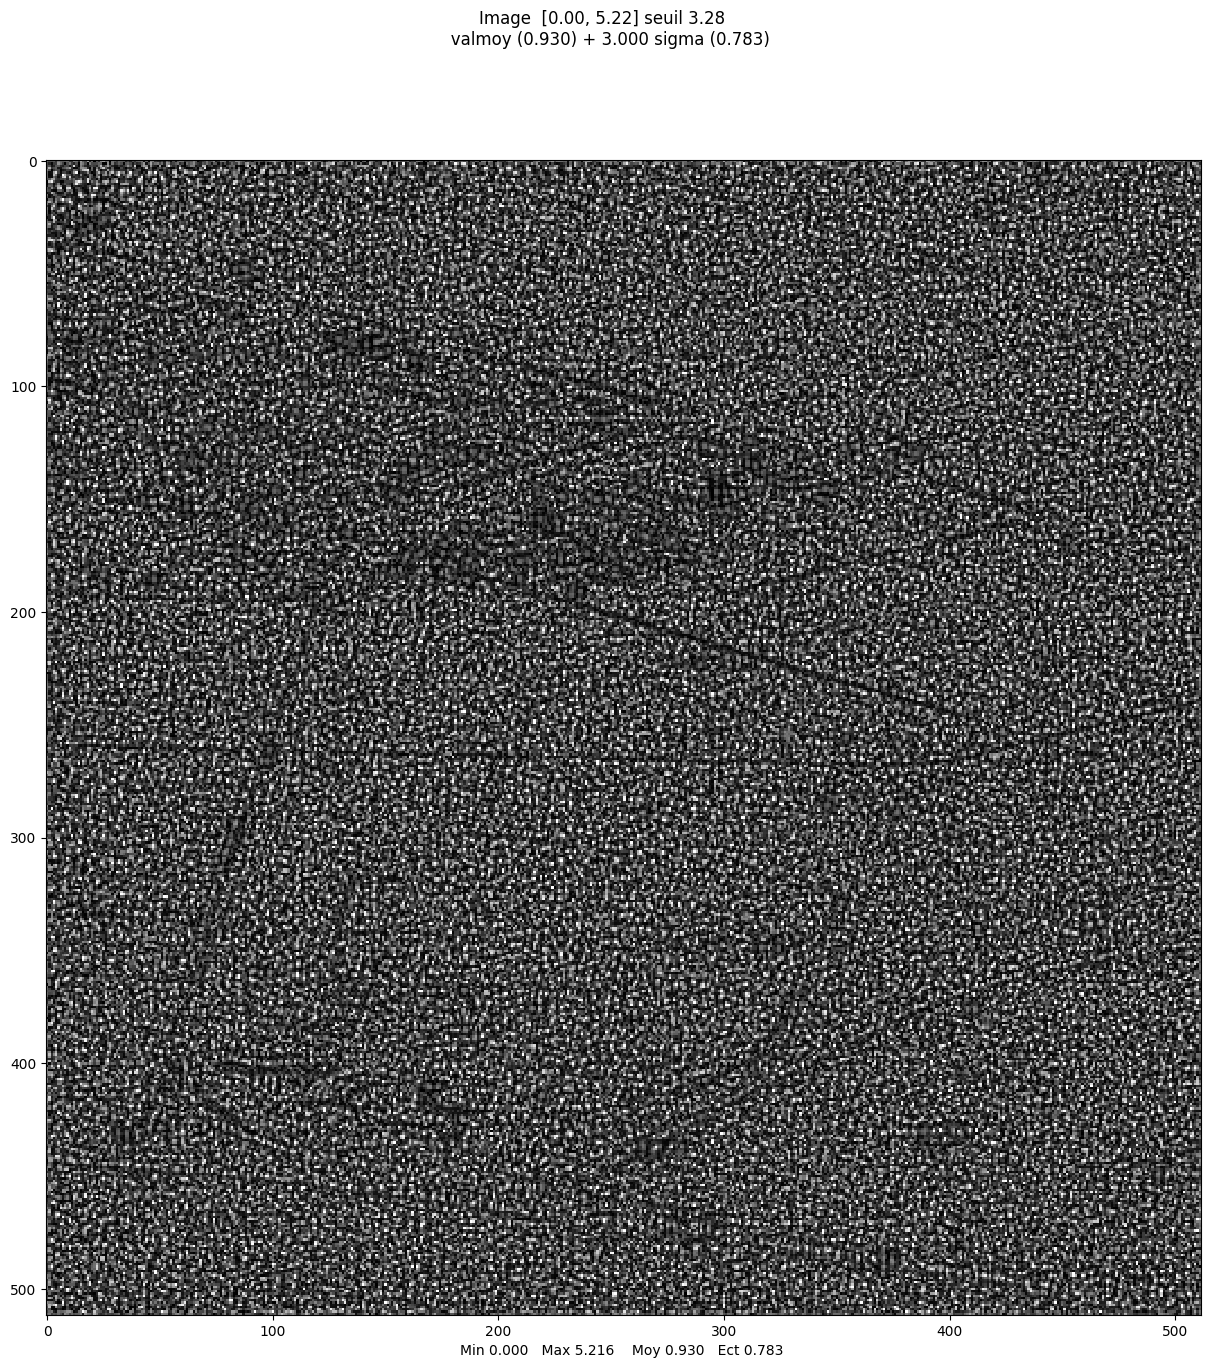

Affichage d'une image reelle
plt.show dans visusar : image 512 x 512


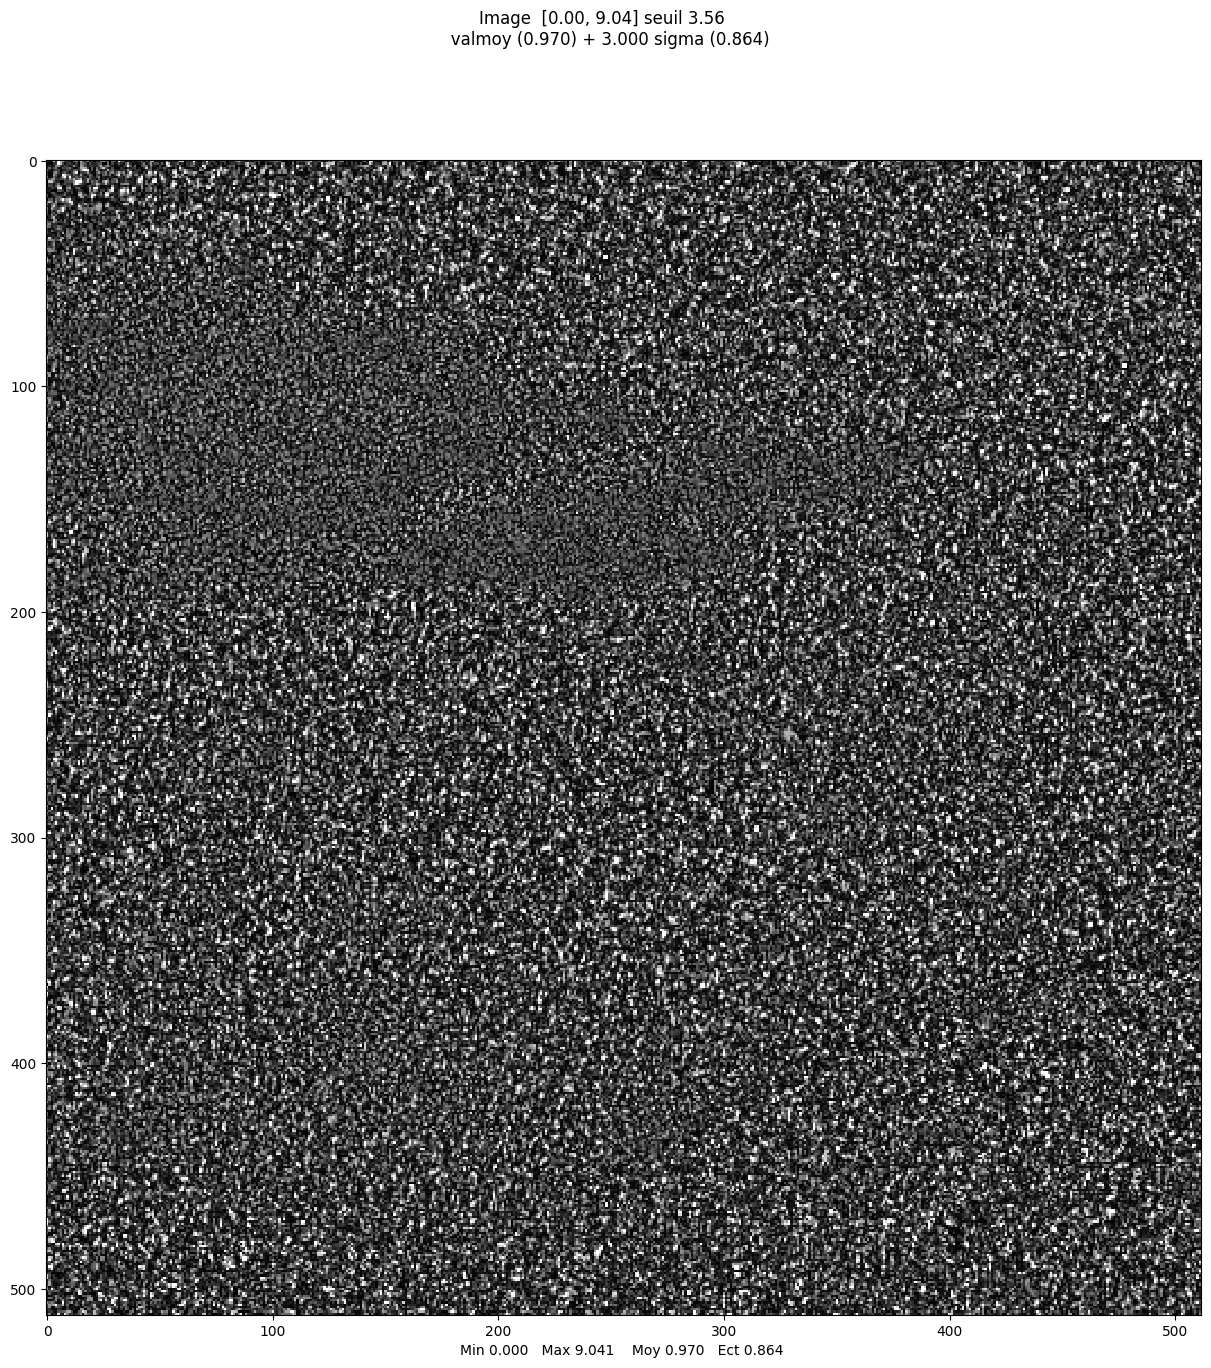

LEE FILTER: mean = 0.9301460471018858 and var = 0.6125495492720925
SAR2SAR: mean = 0.9697834638584217 and var = 0.7457658171745046


In [47]:
# Plot the residual noise
res_noise_lee = np.abs(part_lely_slc)**2/lee_filtered #complete
mvalab.visusar(res_noise_lee)
mean_lee = np.mean(res_noise_lee)
var_lee = np.var(res_noise_lee)

res_noise_deep = np.abs(part_lely_slc)**2/im1_d**2 #complete
mvalab.visusar(res_noise_deep)
mean_deep = np.mean(res_noise_deep)
var_deep = np.var(res_noise_deep)

print('LEE FILTER: mean = '+str(mean_lee)+' and var = '+str(var_lee))
print('SAR2SAR: mean = '+str(mean_deep)+' and var = '+str(var_deep))